In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from cuml.ensemble import RandomForestRegressor as cuRF
from sklearn.ensemble import RandomForestRegressor as RF
import cudf
import cupy
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scripts.function_utils import past_timesteps, test_leave_house_out, total_averaged_metrics, add_energy_variation

#### Output file

In [2]:
sourceFile = open("../../gpu_logs/discard.txt", 'w')

### Load the data

In [ ]:
df = pd.read_csv("../../data/porto.csv", decimal=",", index_col=[0])
df['Energy'] = df['Energy'].astype(np.float32)
df = df.iloc[:, [0, 2, 1]].reset_index(drop=True)
number_of_houses = df.Location.nunique()
df['Time'] = pd.to_datetime(df['Time'])
df.reset_index(drop=True, inplace=True)
df.Location = "Meter" + df['Location'].astype(str)
df

## Save Dataframe with past timesteps

In [ ]:
number_of_timesteps = 672

In [ ]:
df_new = past_timesteps(df, number_of_timesteps)
#df_new

In [ ]:
df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5, 6]).astype(int)
df_new['Hour'] = df_new['Time'].dt.hour
df_new

In [ ]:
X = df_new.drop(["Time", "Location", "Energy"], axis=1)
X

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
df_standardized = pd.DataFrame(scaler.transform(X), columns=X.columns)
df_standardized

In [ ]:
pca = PCA(n_components=20)
pca.fit(df_standardized)
df_pca = pd.DataFrame(pca.transform(df_standardized))
print(pca.explained_variance_ratio_)
df_pca

In [ ]:
not_features = pd.DataFrame(pd.concat([df_new['Time'], df_new["Location"], df_new["Energy"]], axis=1))
df_pca = pd.concat([not_features, df_pca], axis=1)
df_pca

In [ ]:
# df_selected = df_new[["Time","Location","lag_1","lag_2","lag_3","lag_4","lag_96","lag_192","lag_288","lag_384","lag_480","lag_576","lag_672","DayOfWeek","Hour","Energy"]]
# df_selected

In [ ]:
#df_selected.to_csv("../../data/porto_full_selected.csv", index=False)

## Predict  5 folds with 10 random houses for test

In [3]:
df_test = pd.read_csv("../../data/porto_full_selected.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df = pd.read_csv("../../data/porto_full_selected.csv", engine='c', dtype=float32_cols)
df.Location = "Meter" + df['Location'].astype(str)
df

,Time,Location,lag_1,lag_2,lag_3,lag_4,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour,Energy
0,2019-01-08 00:00:00,Meter0,3.952000,3.803000,4.095000,3.926000,2.615000,3.321000,3.066000,2.351000,2.851000,3.054000,2.964000,1,0,4.940000
1,2019-01-08 00:15:00,Meter0,4.940000,3.952000,3.803000,4.095000,2.634000,2.873000,3.152000,2.843000,3.102000,2.677000,2.584000,1,0,4.149000
2,2019-01-08 00:30:00,Meter0,4.149000,4.940000,3.952000,3.803000,3.052000,3.407000,2.633000,2.949000,2.546000,3.522000,3.071000,1,0,4.401000
3,2019-01-08 00:45:00,Meter0,4.401000,4.149000,4.940000,3.952000,2.893000,2.673000,2.590000,2.605000,3.016000,2.729000,2.694000,1,0,4.431000
4,2019-01-08 01:00:00,Meter0,4.431000,4.401000,4.149000,4.940000,2.349000,2.390000,2.330000,3.023000,3.031000,2.368000,2.569000,1,1,3.988000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757659,2020-01-01 22:45:00,Meter50,1.099100,0.453906,0.481770,0.483173,0.641933,0.778195,0.753222,0.641933,0.778195,0.753222,1.723943,2,22,0.753222
1757660,2020-01-01 23:00:00,Meter50,0.753222,1.099100,0.453906,0.481770,0.752850,0.931837,0.716855,0.752850,0.931837,0.716855,1.482914,2,23,0.716855
1757661,2020-01-01 23:15:00,Meter50,0.716855,0.753222,1.099100,0.453906,0.935428,0.937079,0.735802,0.935428,0.937079,0.735802,1.772033,2,23,0.735802
1757662,2020-01-01 23:30:00,Meter50,0.735802,0.716855,0.753222,1.099100,0.715781,0.803087,0.485237,0.715781,0.803087,0.485237,2.535657,2,23,0.485237


In [4]:
num_houses_test = 10
locations = []
for i in range(10):
    np.random.seed(i*42)
    l = np.random.choice(df['Location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array(['Meter29', 'Meter11', 'Meter10', 'Meter22', 'Meter2', 'Meter28',
        'Meter45', 'Meter32', 'Meter26', 'Meter4'], dtype=object),
 array(['Meter43', 'Meter40', 'Meter46', 'Meter12', 'Meter24', 'Meter31',
        'Meter17', 'Meter32', 'Meter3', 'Meter30'], dtype=object),
 array(['Meter35', 'Meter30', 'Meter37', 'Meter7', 'Meter6', 'Meter38',
        'Meter11', 'Meter19', 'Meter5', 'Meter22'], dtype=object),
 array(['Meter35', 'Meter2', 'Meter32', 'Meter5', 'Meter49', 'Meter7',
        'Meter15', 'Meter24', 'Meter25', 'Meter33'], dtype=object),
 array(['Meter30', 'Meter35', 'Meter11', 'Meter39', 'Meter16', 'Meter4',
        'Meter3', 'Meter24', 'Meter18', 'Meter10'], dtype=object),
 array(['Meter26', 'Meter34', 'Meter19', 'Meter15', 'Meter2', 'Meter16',
        'Meter23', 'Meter31', 'Meter13', 'Meter0'], dtype=object),
 array(['Meter39', 'Meter17', 'Meter1', 'Meter26', 'Meter11', 'Meter43',
        'Meter16', 'Meter29', 'Meter23', 'Meter20'], dtype=object),
 array(['Meter36', '

In [5]:
## Number of NaNs
df.isna().sum().sum()

0

In [6]:
#kf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42) 
#locations = []
#for _, test_index in kf.split(df['Location'].unique()):
#    locations.append(test_index)
#locations

In [7]:
n_splits = 10

### Linear Regression

In [ ]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile, split_timeseries=True, cv=i)
    metrics_list_lr.append((rmse, wape, r2))

In [ ]:
metrics_list_lr_pca = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_lr = test_leave_house_out(df_pca, LinearRegression(), locations[i], sourceFile, split_timeseries=True, cv=i)
    metrics_list_lr_pca.append((rmse, wape, r2))

In [8]:
metrics_list_lr_loc = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile, split_timeseries=False)
    metrics_list_lr_loc.append((rmse, wape, r2))


Iteration 0
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.5096
WAPE: 32.57
R2: 0.7334

Iteration 1
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.4459
WAPE: 30.39
R2: 0.7884

Iteration 2
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.5411
WAPE: 32.33
R2: 0.7234

Iteration 3
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.5090
WAPE: 31.01
R2: 0.7239

Iteration 4
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.4744
WAPE: 30.79
R2: 0.7498

Iteration 5
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.5124
WAPE: 24.27
R2: 0.9034

Iteration 6
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.4839
WAPE: 32.75
R2: 0.7169

Iteration 7
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.4449
WAPE: 32.49
R2: 0.7273

Iteration 8
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.49

In [ ]:
metrics_list_lr_pca_loc = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_lr = test_leave_house_out(df_pca, LinearRegression(), locations[i], sourceFile, split_timeseries=False)
    metrics_list_lr_pca_loc.append((rmse, wape, r2))

### XGBoost

In [ ]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.01, max_depth=16, n_estimators=700), locations[i], sourceFile, split_timeseries=True, cv=i)
    metrics_list_xgb.append((rmse, wape, r2))

In [ ]:
metrics_list_xgb_pca = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_xgb = test_leave_house_out(df_pca, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.01, max_depth=16, n_estimators=700), locations[i], sourceFile, split_timeseries=True, cv=i)
    metrics_list_xgb_pca.append((rmse, wape, r2))

In [9]:
metrics_list_xgb_loc = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.01, max_depth=16, n_estimators=700), locations[i], sourceFile, split_timeseries=False)
    metrics_list_xgb_loc.append((rmse, wape, r2))


Iteration 0
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.3514
WAPE: 22.58
R2: 0.8732

Iteration 1
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.3721
WAPE: 23.62
R2: 0.8526

Iteration 2
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.3489
WAPE: 19.93
R2: 0.8849

Iteration 3
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.3760
WAPE: 21.93
R2: 0.8493

Iteration 4
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.3227
WAPE: 19.60
R2: 0.8841

Iteration 5
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 1.0496
WAPE: 19.76
R2: 0.5951

Iteration 6
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.3102
WAPE: 20.65
R2: 0.8836

Iteration 7
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.2433
WAPE: 18.86
R2: 0.9184

Iteration 8
split location
Train set:  (1413024, 16)
Test set:  (344640, 16)
RMSE: 0.33

In [ ]:
metrics_list_xgb_pca_loc = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_xgb = test_leave_house_out(df_pca, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.01, max_depth=16, n_estimators=700), locations[i], sourceFile, split_timeseries=False)
    metrics_list_xgb_pca_loc.append((rmse, wape, r2))

### Random Forest

In [ ]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_rf = test_leave_house_out(df, cuRF(bootstrap=True, max_depth=16, min_samples_leaf=1, min_samples_split=2,n_estimators=700), locations[i], sourceFile, split_timeseries=True, cv=i, gpu=False)
    metrics_list_rf.append((rmse, wape, r2))

In [ ]:
metrics_list_rf_pca = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_rf = test_leave_house_out(df_pca, cuRF(bootstrap=True, max_depth=16, min_samples_leaf=1, min_samples_split=2,n_estimators=700), locations[i], sourceFile, split_timeseries=True, cv=i, gpu=False)
    metrics_list_rf_pca.append((rmse, wape, r2))

In [ ]:
metrics_list_rf_loc = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_rf = test_leave_house_out(df, cuRF(bootstrap=True, max_depth=16, min_samples_leaf=1, min_samples_split=2,n_estimators=700), locations[i], sourceFile, split_timeseries=False, gpu=False)
    metrics_list_rf_loc.append((rmse, wape, r2))

In [ ]:
metrics_list_rf_pca_loc = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_rf = test_leave_house_out(df_pca, cuRF(bootstrap=True, max_depth=16, min_samples_leaf=1, min_samples_split=2,n_estimators=700), locations[i], sourceFile, split_timeseries=False, gpu=False)
    metrics_list_rf_pca_loc.append((rmse, wape, r2))

## Averaged Metrics

In [ ]:
print("\n\n\n", file=sourceFile)

In [ ]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)
total_averaged_metrics(metrics_list_lr_pca, sourceFile)
total_averaged_metrics(metrics_list_lr_loc, sourceFile)
total_averaged_metrics(metrics_list_lr_pca_loc, sourceFile)

In [10]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)
total_averaged_metrics(metrics_list_xgb_pca, sourceFile)
total_averaged_metrics(metrics_list_xgb_loc, sourceFile)
total_averaged_metrics(metrics_list_xgb_pca_loc, sourceFile)

Total Averaged RMSE: 0.397
Total Averaged WAPE: 20.857
Total Averaged R2: 0.851


(0.397, 20.857, 0.851)

In [ ]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)
total_averaged_metrics(metrics_list_rf_pca, sourceFile)
total_averaged_metrics(metrics_list_rf_loc, sourceFile)
total_averaged_metrics(metrics_list_rf_pca_loc, sourceFile)

In [ ]:
sourceFile.close()

### Feature Importance

In [11]:
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

XGBoost

Feature: 0, Score: 0.49140
Feature: 1, Score: 0.10580
Feature: 2, Score: 0.04320
Feature: 3, Score: 0.02314
Feature: 4, Score: 0.03137
Feature: 5, Score: 0.03002
Feature: 6, Score: 0.06270
Feature: 7, Score: 0.04422
Feature: 8, Score: 0.02134
Feature: 9, Score: 0.02468
Feature: 10, Score: 0.02567
Feature: 11, Score: 0.07248
Feature: 12, Score: 0.02396


In [12]:
model_xgb.feature_importances_

array([0.49140155, 0.10580443, 0.04320302, 0.02314029, 0.03136947,
       0.03002426, 0.06270386, 0.04421767, 0.02133822, 0.02467958,
       0.02567356, 0.07248212, 0.0239619 ], dtype=float32)

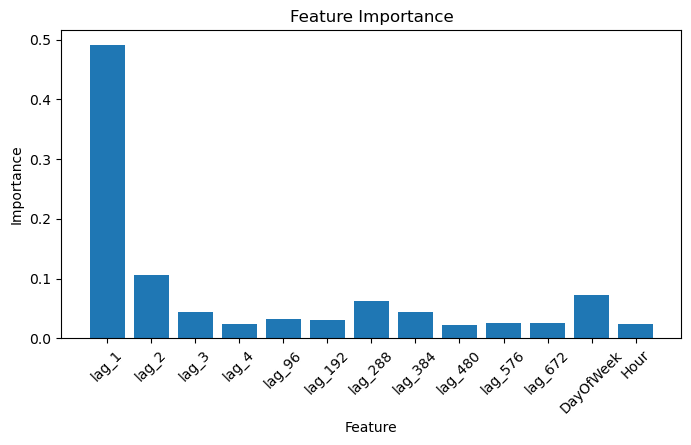

In [18]:
plt.figure(figsize=(8,4))
plt.bar(df.columns[2:-1],model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.savefig("../../images/main/porto_xgb_feat_imp_loc.png")
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(df.columns[2:-1],model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
columns = df.drop(["Energy", "Location", "Time"], axis=1).columns
feature_importance = pd.Series(model_xgb.feature_importances_, index=columns)
feature_importance

In [ ]:
features = feature_importance.nlargest(40).index
features

In [ ]:
df_40 = df[['Time', 'Location'] + [*features] + ['Energy']]
df_40

In [ ]:
df_40.to_csv("data/porto_best40features.csv", index=False)

## Hyperparameter Tuning

In [ ]:
df_test = pd.read_csv("../../data/porto_full_selected.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df_tuning = pd.read_csv("../../data/porto_full_selected.csv", engine='c', dtype=float32_cols)
df_tuning.drop(['Time', 'Location'], axis=1, inplace=True)
df_tuning

In [ ]:
undersample_data = df_tuning.loc[np.linspace(df_tuning.index.min(),df_tuning.index.max(),400000).astype(int)]
#undersample_time = df_index.loc[np.linspace(df_index.index.min(),df_index.index.max(),8784).astype(int)]
undersample_data = undersample_data.reset_index().drop('index',axis=1)
undersample_data

In [ ]:
params_rf = {
    'bootstrap': [True],
    'max_depth': [8, 12, 16],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 8, 10],
    'n_estimators': [500, 700]
}

In [ ]:
params_xgb = { 
    'max_depth': [10, 16],
    'learning_rate': [0.001, 0.01, 0.05],
    'n_estimators': [500, 700],
    'colsample_bytree': [0.3, 0.7]
}

In [ ]:
train_features = undersample_data.drop('Energy', axis=1)
train_labels = undersample_data['Energy']
test_features = 0
test_labels = 0

### XGBoost Best Parameters

In [ ]:
xgb_model = xgb.XGBRegressor(tree_method="gpu_hist", seed=42)
grid_search = GridSearchCV(estimator = xgb_model, param_grid = params_xgb, cv = 3, n_jobs = 4, verbose = 2, scoring="r2")

In [ ]:
grid_search.fit(train_features, train_labels)

In [ ]:
grid_search.best_params_
#{'colsample_bytree': 0.7,
#'learning_rate': 0.1,
#'max_depth': 10,
#'n_estimators': 1000}

In [ ]:
{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 16,
 'n_estimators': 700}

In [ ]:
grid_search.best_score_

### Random Forest Best Parameters

In [ ]:
rf = cuRF()
grid_search_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 3, n_jobs = 8, verbose = 2, scoring="r2")

In [ ]:
grid_search_rf.fit(train_features, train_labels)

In [ ]:
print(grid_search_rf.best_params_)
best_grid = grid_search_rf.best_estimator_
#grid_accuracy = evaluate(best_grid, test_features, test_labels)

In [ ]:
filee = open("rf_params.txt","w")
print(grid_search.best_params_, file=filee)
filee.close()

In [ ]:
{'bootstrap': True, 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700}